In [2]:
from typing import Tuple

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

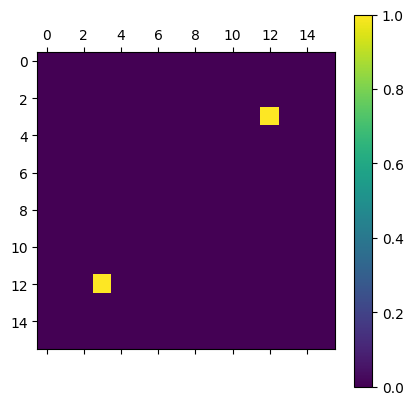

In [8]:
sp = np.array([[0, 1], [0, 0]])
sm = np.array([[0, 0], [1, 0]])
plaqutte = np.kron(sp, np.kron(sp, np.kron(sm, sm)))
plaqutte_conj = np.kron(sm, np.kron(sm, np.kron(sp, sp)))
flipper = plaqutte + plaqutte_conj
plt.matshow(flipper)
plt.colorbar()

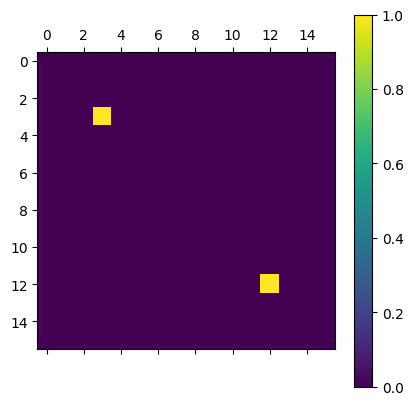

In [9]:
plt.matshow(flipper @ flipper)
plt.colorbar()

In [ ]:
class HigherOrderTensorRG:
    def __init__(self, init_tensor: np.ndarray, bond_dim: int):
        self.init_tensor = init_tensor
        self.bond_dim = bond_dim

    def higher_order_svd(self, transfer_tensor: np.ndarray, axes: Tuple[int, int]) -> np.ndarray:
        Us = []
        Ss = []
        for axis in axes:
            tmp_ts = np.copy(transfer_tensor)
            if axis > 0:
                for roll in range(4 - axis):
                    tmp_ts = np.moveaxis(tmp_ts, -1, 0)
            tmp_ts = np.ndarray.reshape(tmp_ts, (tmp_ts.shape[0], tmp_ts.size // tmp_ts.shape[0]))
            x, s, y = np.linalg.svd(tmp_ts, full_matrices=False)
            Us.append(x)
            Ss.append(s)

        epsilon1 = np.sum(np.square(np.delete(Ss[0], np.arange(self.bond_dim))))
        epsilon2 = np.sum(np.square(np.delete(Ss[1], np.arange(self.bond_dim))))
        if epsilon1 < epsilon2:
            U = Us[0][:, 0:self.bond_dim]
        else:
            U = Us[1][:, 0:self.bond_dim]
        return U

    def norm(self, transfer_tensor: np.ndarray) -> float:
        norm = np.linalg.norm(
            np.ndarray.reshape(transfer_tensor, (self.bond_dim ** 2, self.bond_dim ** 2)))
        if np.isinf(norm) or norm <= 0:
            raise ValueError(f"Got unexpected norm of transfer tensor {norm}")
        return norm

    def run(self, max_step: int):
        norm_histo = []
        T = self.init_tensor
        for step in range(1, max_step + 1):
            print(f"In RG step {step}")
            # X direction
            M = np.tensordot(T, T, axes=(3, 1))
            M = np.swapaxes(M, 1, 3)
            M = np.swapaxes(M, 2, 3)
            M = np.swapaxes(M, 0, 1)
            M = np.ndarray.reshape(M, (self.bond_dim ** 2, self.bond_dim, self.bond_dim ** 2, self.bond_dim))
            U = self.higher_order_svd(M, axes=(0, 2))
            T = np.tensordot(np.tensordot(M, U, axes=(0, 0)), U, axes=(1, 0))
            T = np.swapaxes(T, 0, 2)
            T = np.swapaxes(T, 1, 2)
            T = np.swapaxes(T, 2, 3)
            # Y direction
            M = np.tensordot(T, T, axes=(2, 0))
            M = np.swapaxes(M, 3, 4)
            M = np.swapaxes(M, 2, 4)
            M = np.swapaxes(M, 4, 5)
            M = np.ndarray.reshape(M, (self.bond_dim, self.bond_dim ** 2, self.bond_dim, self.bond_dim ** 2))
            U = self.higher_order_svd(M, axes=(1, 3))
            T = np.tensordot(np.tensordot(M, U, axes=(1, 0)), U, axes=(2, 0))
            T = np.swapaxes(T, 1, 2)
            # normalized factor
            norm = self.norm(T)
            norm_histo.append(norm)
            T /= norm
        return T, norm_histo

In [3]:
from scipy.linalg import expm

sz = np.array([[1, 0], [0, -1]], dtype=float)
botzmann = expm(np.kron(sz, sz))
u, s, v = np.linalg.svd(botzmann)
print(u)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
